In [1]:
import sys; sys.path.append('..')
from osp import *
import html


In [2]:
for id,docstr in STASH_SLICES_NLP.items():
    break
# doc=stanza.Document.from_serialized(docstr)
# sent = random.choice(doc.sentences)
txt = """
These words, it seems to me, give us a particular picture of the
essence of human language. It is this: the individual words in language
name objects—sentences are combinations of such names.——In this
picture of language we find the roots of the following idea: Every word
has a meaning. This meaning is correlated with the word. It is the
object for which the word stands.
"""

doc = get_nlp_doc(txt)
sent = doc.sentences[0]

In [3]:
# get_clauses(sent)

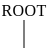

In [6]:
get_sent_tree_full(sent)

In [8]:
tree = get_sent_tree(sent)

In [9]:
str(sent.constituency)

'(ROOT (S (NP (DT These) (NNS words)) (PRN (, ,) (S (NP (PRP it)) (VP (VBZ seems) (PP (IN to) (NP (PRP me))))) (, ,)) (VP (VB give) (NP (PRP us)) (NP (NP (DT a) (JJ particular) (NN picture)) (PP (IN of) (NP (NP (DT the) (NN essence)) (PP (IN of) (NP (JJ human) (NN language))))))) (. .)))'

In [9]:
def get_sent_html(sent, color=COLOR_SENT_BY_COL, max_score=COLOR_MAX_SCORE, min_score=COLOR_MIN_SCORE, color_by=COLOR_MAX_SCORE, word_feat_type=COLOR_SENT_BY_FEAT, df_feats=None, font_size="1.2em", show_labels=False):
    """
    Returns HTML for a stanza Sentence, with words colored by feature weights.
    """
    if df_feats is None:
        df_feats = get_current_feat_weights()

    df_words = get_clauses(sent).reset_index()
    
    sent_html = []
    
    for (clause_num,clause_type),clause_df in df_words.groupby(['clause_num','clause_type']):
        for i,row in clause_df.iterrows():
            # Match the feature naming convention used in the codebase (pos_TAG, deprel_REL)
            word = row['word']
            pos = row['pos']
            deprel = row['deprel']
            word_num = row['word_num']
            feat_name = f'deprel_{deprel}' if word_feat_type == 'deprel' else f'pos_{pos}'
            
            # Use get_color for consistent coloring with displaCy
            bg_color = get_color(feat_name, color_by=color, df_feats=df_feats, vmin=min_score, vmax=max_score)
            
            # Determine if text should be white or black for readability
            val = df_feats.loc[feat_name, color] if feat_name in df_feats.index else 0
            
            # Normalize val for contrast checking
            if min_score < 0 < max_score:
                intensity = val / max_score if val > 0 else val / abs(min_score)
            elif max_score != min_score:
                intensity = (val - (min_score + max_score) / 2) / ((max_score - min_score) / 2)
            else:
                intensity = 0
                
            text_color = 'white' if abs(intensity) > 0.7 else 'black'
            
            # Escape text for safety and create annotated span
            safe_text = html.escape(word)
            # posdeprel = deprel if word_feat_type == 'deprel' else pos
            posdeprel = f'{pos}/{deprel}' if show_labels else ''
            
            label_style = f"opacity: 0.7;" if show_labels else "display: none;"
            
            word_span = (
                f'<span style="background-color: {bg_color}; color: {text_color}; font-size: {font_size}; font-weight: normal; '
                f'display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; '
                f'padding: 2px 4px; border-radius: 4px; margin: 1px;">'
                f'{safe_text}'
                f'<sub style="display: block; font-size: 0.6em; {label_style} line-height: 1; font-weight: normal; padding: 2px; font-family: monospace;">'
                f'{posdeprel}</sub>'
                f'</span>'
            )
            sent_html.append(word_span)
        sent_html.append('<br>')
    return "".join(sent_html)

In [12]:
HTML(get_sent_html(sent))

In [75]:
get_clauses(sent)

word  pos     deprel  head
clause_num clause_type word_num                                  
1          IC          1              These   DT        det     2
                       2              words  NNS      nsubj     9
                       3                  ,    ,      punct     2
2          IC          4                 it  PRP      nsubj     5
                       5              seems  VBZ  parataxis     9
                       6                 to   IN       case     7
                       7                 me  PRP        obl     5
                       8                  ,    ,      punct     5
                       9               give   VB       root     0
                       10                us  PRP       iobj     9
                       11                 a   DT        det    13
                       12        particular   JJ       amod    13
                       13           picture   NN        obj     9
                       14                of   IN       case    16
                       15               the   DT        det    16
                       16           essence   NN       nmod    13
                       17                of   IN       case    19
                       18             human   JJ       amod    19
                       19          language   NN       nmod    16
                       20                 .    .      punct     9

In [ ]:
def detokenize_sent(sent):
    l = []
    for tok in sent.tokens:
        l.append(tok.text)
        l.append(tok.spaces_after)
    return ''.join(l).strip()

def is_valid_sent_feat(k):
    for bw in ['parens','punct','noun','verb','adjective']:
        if bw in k:
            return False
    return True

def get_sent_feats(sent,per_n_words=None):
    tree = get_sent_tree(sent)
    feats = get_tree_stats(tree)
    feats['sent'] = detokenize_sent(sent)
    feats = {k:v for k,v in feats.items() if k=='sent' or is_valid_sent_feat(k)}
    if per_n_words:
        num_words = get_num_words(tree)
        feats['num_words'] = num_words
        for k,v in feats.items():
            if isinstance(v,(int,float)):
                feats[k] = v / per_n_words
    html = get_sent_html(sent, color='weight_z', min_score=-2, max_score=2,show_labels=True, color_by='weight_z')
    return {'sent_i':sent.index, 'html':html, **feats}

def get_sents_feats(doc,per_n_words=None):
    return pd.DataFrame(get_sent_feats(sent,per_n_words) for sent in doc.sentences)

def get_sents_feats_df(doc,per_n_words=None, color_by='weight_z', html=False, with_weights=False):
    df = get_sents_feats(doc,per_n_words)
    if not html: 
        df = df.drop(columns=['html'])
    else:
        df = df.drop(columns=['sent']).rename(columns={'html':'sent'})
    if with_weights:
        df2 = get_sent_weights(doc, color_by=color_by).drop(columns=['sent'])
        df = df.merge(df2, on='sent_i', how='left')
        
    df['sent_num']=df['sent_i']+1
    df = df.drop(columns=['sent_i'])
    df.columns=[col.replace('_',' ').title() if not '(' in col and col != 'html' else col for col in df.columns]
    return df.set_index(['Sent Num'])

def get_sent_weights(doc, color_by='weight_z'):
    o = []
    # weights = get_current_feat_weights(group_by=('feature',))
    weights_cmp = get_current_feat_weights(group_by=('comparison',))[color_by]

    dfx=get_slice_feats_by_word(doc, color_by)
    dfx_all_s = dfx.groupby(['sent_i']).mean(numeric_only=True).reset_index().set_index('sent_i')[color_by]
    dfx_feat = dfx.groupby(['sent_i','feat_type']).mean(numeric_only=True).reset_index().set_index('sent_i')
    dfx_feat_piv = dfx_feat.reset_index().pivot(index='sent_i', columns='feat_type', values='weight_z')

    for sent_i, sent in enumerate(doc.sentences):
        out_d = {'sent_i':sent_i, 'sent':detokenize_sent(sent)}
        out_d['P(Phil)'] = dfx_all_s.loc[sent_i]
        
        sentrow = dfx_feat_piv.loc[sent_i]
        for col in sentrow.index:
            out_d[f'P(Phil|{col})'] = sentrow.loc[col]

        for cmp,score in weights_cmp.items():
            out_d[f'P(Phil|{cmp.split("-")[0]})'] = score
        o.append(out_d)
    return pd.DataFrame(o)
    
    
    

    for sent_i, sent in enumerate(doc.sentences):
        out_d = {'sent_i':sent_i, 'sent':detokenize_sent(sent)}
        

In [70]:
# df = get_sent_weights(doc)
# df

In [72]:
get_sents_feats_df(doc, color_by='weight_z', html=True, with_weights=True)

,Sent,Num Words,Height,Num Independent Clauses,Num Dependent Clauses,Num Words In Dependent Clauses,Num Words In Independent Clauses,P(Phil),P(Phil|deprel),P(Phil|pos),P(Phil|sent),P(Phil|1900),P(Phil|1925),P(Phil|1950),P(Phil|1975),P(Phil|2000)
Sent Num,,,,,,,,,,,,,,,,
1,"<span style=""background-color: #f5a886; color: black; font-size: 1.2em; font-weight: normal; display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; padding: 2px 4px; borde...",20,10,2,0,0,20,-0.133354,-0.198649,-0.119262,0.071455,1.076098,-0.709219,-0.744007,1.114405,-0.737276
2,"<span style=""background-color: #fbceb7; color: black; font-size: 1.2em; font-weight: normal; display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; padding: 2px 4px; borde...",20,9,3,0,0,20,-0.036183,0.053941,-0.153216,0.071455,1.076098,-0.709219,-0.744007,1.114405,-0.737276
3,"<span style=""background-color: #f9ebe3; color: black; font-size: 1.2em; font-weight: normal; display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; padding: 2px 4px; borde...",21,9,2,0,0,21,-0.099560,-0.158431,-0.081408,0.071455,1.076098,-0.709219,-0.744007,1.114405,-0.737276
4,"<span style=""background-color: #f5a886; color: black; font-size: 1.2em; font-weight: normal; display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; padding: 2px 4px; borde...",8,8,1,0,0,8,-0.061042,-0.099936,-0.104957,0.071455,1.076098,-0.709219,-0.744007,1.114405,-0.737276
5,"<span style=""background-color: #fbceb7; color: black; font-size: 1.2em; font-weight: normal; display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; padding: 2px 4px; borde...",10,9,1,1,5,5,-0.014309,-0.126890,0.055390,0.071455,1.076098,-0.709219,-0.744007,1.114405,-0.737276


In [60]:
df=get_sents_feats(doc)
df=df.drop(columns=['sent'])
df['sent_num']=df['sent_i']+1
df = df.set_index(['sent_num']).drop(columns=['sent_i'])
df.columns=[col.replace('_',' ').title() if col != 'html' else col for col in df.columns]
df

,html,Num Words,Height,Num Independent Clauses,Num Dependent Clauses,Num Words In Dependent Clauses,Num Words In Independent Clauses
sent_num,,,,,,,
1,"<span style=""background-color: #f5a886; color: black; font-size: 1.2em; font-weight: normal; display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; padding: 2px 4px; borde...",20,10,2,0,0,20
2,"<span style=""background-color: #fbceb7; color: black; font-size: 1.2em; font-weight: normal; display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; padding: 2px 4px; borde...",20,9,3,0,0,20
3,"<span style=""background-color: #f9ebe3; color: black; font-size: 1.2em; font-weight: normal; display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; padding: 2px 4px; borde...",21,9,2,0,0,21
4,"<span style=""background-color: #f5a886; color: black; font-size: 1.2em; font-weight: normal; display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; padding: 2px 4px; borde...",8,8,1,0,0,8
5,"<span style=""background-color: #fbceb7; color: black; font-size: 1.2em; font-weight: normal; display: inline-block; text-align: left; vertical-align: top; line-height: 1.2; padding: 2px 4px; borde...",10,9,1,1,5,5


In [53]:
# Option 1: quick inline display (keeps index/other cols)
HTML(df.to_html(escape=False))

In [3]:
# render_sent_weighted(sent)

In [4]:
# def get_all_sent_html(sent):
#     psg = get_sent_html(sent)
#     diagram = render_sent_displacy(sent, jupyter=False)
#     return f'''
#     <div style="display: flex; flex-direction: row; gap: 10px;">
#     <div style="flex: 1; min-width: 300px;">{psg}</div><div style="flex: 1; min-width: 0; zoom: 0.5;">{diagram}</div>
#     </div>
#     '''


In [5]:
# pprint(render_sent_displacy(get_sent_obj("Hello"), jupyter=False))

In [6]:

HTML(get_doc_html(get_nlp_doc("This is the worst trash of the world. He came through the back door.")))

In [7]:
HTML(get_all_sent_html(sent))